__NAME:__ __Nigel Mansell__  
__SECTION:__ __995__  
__CS 5970: Machine Learning Practices__

# Homework 11: Dimensionality Reduction

## Assignment Overview
Follow the TODOs and read through and understand any provided code.  
For all plots, make sure all necessary axes and curves are clearly and 
accurately labeled. Include figure/plot titles appropriately as well.


### Task
For this assignment you will be exploring dimensionality reduction using
Prinicipal Componenet Analysis (PCA). Having a large number of features 
can dramatically increase training times and the likelihood of overfitting.
Additionally, it's difficult to visualize and understand patterns in high 
dimensional spaces. It's not uncommon that a lower dimensional subspace
of the full feature space will better characterize trends within the data.
PCA is one such technique that attempts to locate such subspaces and projects
the data into the determined subspace.


### Data set   
The BMI data will be utilized. Recall:  
* _MI_ files contain data with the number of action potentials (spikes) for 48 neurons, at mutliple 
time points, for a single fold. There are 20 folds (20 files), where each fold consists 
of over 1000 times points (the rows). At each time point, we record the number of 
activations for each neuron for 20 bins. Therefore, each time point has 48 * 20 = 960 
columns.   
* _theta_ files record the angular position of the shoulder (in column 0) and the elbow 
(in column 1) for each time point.   
* _dtheta_ files record the angular velocity of the shoulder (in column 0) and the elbow 
(in column 1) for each time point.   
* _torque_ files record the torque of the shoulder (in column 0) and the elbow (in column 
1) for each time point.   
* _time_ files record the actual time stamp of each time point.  


### Objectives
* Dimensionality Reduction
* Principal Component Analysis (PCA)

### General References
* [Guide to Jupyter](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook)
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Numpy Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [DataCamp: Matplotlib](https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332661264365&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=9026223&gclid=CjwKCAjw_uDsBRAMEiwAaFiHa8xhgCsO9wVcuZPGjAyVGTitb_-fxYtkBLkQ4E_GjSCZFVCqYCGkphoCjucQAvD_BwE)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [Sci-kit Learn Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [Sci-kit Learn Preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
* [SciPy Paired t-test for Dependent Samples](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html)

### Hand-In Procedure
* Execute all cells so they are showing correct results
* Notebook:
  + Submit this file (.ipynb) to the Canvas HW11 dropbox
* PDF:
  + File/Print/Print to file -> Produces a copy of the notebook in PDF format
  + Submit the PDF file to the Gradescope HW11 dropbox

In [1]:
import visualize
import metrics_plots
from pipeline_components import DataSampleDropper, DataFrameSelector
from pipeline_components import DataScaler, DataLabelEncoder

from KFoldHolisticCrossValidation import KFoldHolisticCrossValidation, generate_paramsets


import pandas as pd
import numpy as np
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools
import time as timelib
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import explained_variance_score, confusion_matrix
from sklearn.metrics import mean_squared_error, roc_curve, auc, f1_score
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
import joblib
FIGWIDTH = 5
FIGHEIGHT = 5
FONTSIZE = 10

plt.rcParams['figure.figsize'] = (FIGWIDTH, FIGHEIGHT)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline
#https://matplotlib.org/3.1.1/tutorials/introductory/images.html
plt.style.use('ggplot')

In [2]:
""" PROVIDED
Display current working directory of this notebook. If you are using 
relative paths for your data, then it needs to be relative to the CWD.
"""
HOME_DIR = pathlib.Path.home()
pathlib.Path.cwd()

PosixPath('/home/nigel/Desktop/mlp/homework11')

# LOAD DATA

In [3]:
""" PROVIDED """
def read_bmi_file_set(directory, filebase):
    '''
    Read a set of CSV files and append them together
    :param directory: The directory in which to scan for the CSV files
    :param filebase: A file specification that potentially includes wildcards
    :returns: A list of Numpy arrays (one for each fold)
    '''
    
    # The set of files in the directory
    files = fnmatch.filter(os.listdir(directory), filebase)
    files.sort()

    # Create a list of Pandas objects; each from a file in the directory that matches filebase
    lst = [pd.read_csv(directory + "/" + file, delim_whitespace=True, header=None).values for file in files]
    
    # Concatenate the Pandas objects together.  ignore_index is critical here so that
    # the duplicate row indices are addressed
    return lst

In [4]:
""" TODO
Load the BMI data from all the folds
From the MI_folds we will predict torque_folds
"""
# may need to adjust file path if you are not working on oscer
dir_name = '/home/nigel/Desktop/mlp/mlp_2020/datasets/bmi/DAT6_08'
MI_folds = read_bmi_file_set(dir_name, 'MI_fold*') 
theta_folds = read_bmi_file_set(dir_name, 'theta_fold*')
dtheta_folds = read_bmi_file_set(dir_name, 'dtheta_fold*')
torque_folds = read_bmi_file_set(dir_name, 'torque_fold*')
time_folds = read_bmi_file_set(dir_name, 'time_fold*')

nfolds = len(MI_folds)
nfolds

20

In [5]:
""" PROVIDED
Print out the shape of all the data for each fold
"""
# Zip all data together for convenience when looping
alldata_folds = zip(MI_folds, theta_folds, dtheta_folds, 
                    torque_folds, time_folds)
for i, (MI, theta, dtheta, torque, time) in enumerate(alldata_folds):
    print("FOLD %2d " % i, MI.shape, theta.shape, 
          dtheta.shape, torque.shape, time.shape)

FOLD  0  (1194, 960) (1194, 2) (1194, 2) (1194, 2) (1194, 1)
FOLD  1  (1105, 960) (1105, 2) (1105, 2) (1105, 2) (1105, 1)
FOLD  2  (1532, 960) (1532, 2) (1532, 2) (1532, 2) (1532, 1)
FOLD  3  (1266, 960) (1266, 2) (1266, 2) (1266, 2) (1266, 1)
FOLD  4  (1499, 960) (1499, 2) (1499, 2) (1499, 2) (1499, 1)
FOLD  5  (1253, 960) (1253, 2) (1253, 2) (1253, 2) (1253, 1)
FOLD  6  (1376, 960) (1376, 2) (1376, 2) (1376, 2) (1376, 1)
FOLD  7  (1131, 960) (1131, 2) (1131, 2) (1131, 2) (1131, 1)
FOLD  8  (1248, 960) (1248, 2) (1248, 2) (1248, 2) (1248, 1)
FOLD  9  (1258, 960) (1258, 2) (1258, 2) (1258, 2) (1258, 1)
FOLD 10  (1266, 960) (1266, 2) (1266, 2) (1266, 2) (1266, 1)
FOLD 11  (1147, 960) (1147, 2) (1147, 2) (1147, 2) (1147, 1)
FOLD 12  (1226, 960) (1226, 2) (1226, 2) (1226, 2) (1226, 1)
FOLD 13  (1239, 960) (1239, 2) (1239, 2) (1239, 2) (1239, 1)
FOLD 14  (1571, 960) (1571, 2) (1571, 2) (1571, 2) (1571, 1)
FOLD 15  (1360, 960) (1360, 2) (1360, 2) (1360, 2) (1360, 1)
FOLD 16  (1580, 960) (15

In [6]:
""" PROVIDED
Summary statistics
"""
print("Means")
all_MI = np.concatenate(MI_folds, axis=0)
all_theta = np.concatenate(theta_folds, axis=0)
all_dtheta = np.concatenate(dtheta_folds, axis=0)
all_torque = np.concatenate(torque_folds, axis=0)
all_time = np.concatenate(time_folds, axis=0)

df = np.concatenate(([all_MI.mean()], np.mean(all_theta, axis=0), np.mean(all_dtheta, axis=0), 
                     np.mean(all_torque, axis=0))).reshape(1,-1)
df = pd.DataFrame(df, columns=['MI', 'Should. angle', 'Elbow angle', 
                               'Should. d_angle', 'Elbow d_angle', 
                               'Should. torque', 'Elbow torque'])
print(df)

Means
        MI  Should. angle  Elbow angle  Should. d_angle  Elbow d_angle  \
0  0.52154       0.178253     1.617722         0.011528      -0.005523   

   Should. torque  Elbow torque  
0       -0.000565      0.001704  


# REGRESSION
From the MI_folds we will predict torque_folds

In [7]:
""" PROVIDED
Evaluate the training performance of an already trained model
"""
def compute_rmse(x, y):
    return np.sqrt(np.nanmean((x - y)**2))

def predict_score_rmse(model, X, y):
    '''
    Compute the model predictions and cooresponding scores.
    PARAMS:
        X: feature data
        y: corresponding output
    RETURNS:
        rmse: root mean squared error
        score: score computed by the models score() method
        preds: predictions of the model from X
    '''
    preds = model.predict(X)
    score = model.score(X, y)
    rmse = compute_rmse(y, preds)
    return rmse, score, preds

def predict_plot(model, X, y, time, titles, xlims=None):
    '''
    Compute the model's predicted output
    PARAMS:
        model: already trained model
        X: inputs
        y: outputs 
        * For plots
        time: time axis of timestamps
        titles: subplot titles for each output column
        xlims: two element list of the x limits for the plot
    '''
    # Compute and evaulate  predictions on the model
    rmse, score, preds = predict_score_rmse(model, X, y)
    print("RMSE: %.3f" % rmse)
    print("R^2: %.3f" % score)

    noutputs = y.shape[1]
    
    # Construct the plots
    fig, axs = plt.subplots(noutputs,1, figsize=(25,4))
    fig.subplots_adjust(hspace=.5)
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        ax.plot(time, preds[:,i], 'r', label='Prediction')
        ax.plot(time, y[:,i], 'b', label='True')
        ax.set(title=titles[i], ylabel=r'$\tau$ (N-m)')
        ax.set(xlim=xlims)
    axs[-1].set(xlabel='Time (s)')
    axs[0].legend()

In [8]:
""" TODO
Obtain the first 1 folds (i.e. index 0)

Split the data into X (i.e. the MI_folds) and y (i.e. the torque_folds).

Hold out a subset of the data, before training and cross validation
"""
# List of the output column names
output_names = ['Shoulder', 'Elbow']
# TODO: Grab the first fold
Xtrain = MI_folds[0]
ytrain = torque_folds[0]
time_trn = time_folds[0]

# TODO: Obtain 2nd to last fold for validation
Xval = MI_folds[-2]
yval = torque_folds[-2]
time_val = time_folds[-2]

# TODO: Obtain last fold for testing
Xtest = MI_folds[-1]
ytest = torque_folds[-1]
time_test = time_folds[-1]

nfeatures = Xtrain.shape[1]

Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((1194, 960), (1194, 2), (1390, 960), (1390, 2), (1290, 960), (1290, 2))

# BENCHMARK
The task is to predict shoulder and elbow __torque__ from the neural activations.
We are going to compare the performance of the LinearRegression model trained on the original data to the LinearRegression model trained on the PCA transformed data.

## LinearRegresson Benchmark

RMSE: 0.017
R^2: 0.959


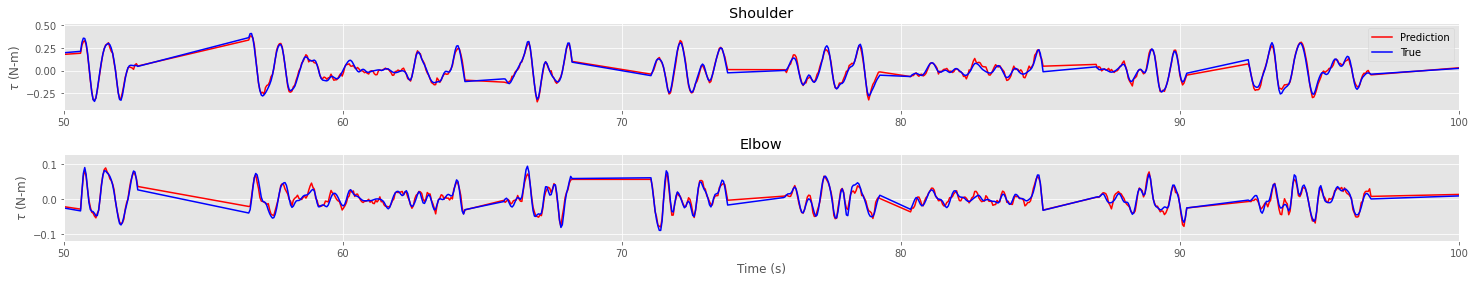

In [9]:
""" PROVIDED
LinearRegression benchmark for comparision
"""
benchmark_lnr = LinearRegression()
benchmark_lnr.fit(Xtrain, ytrain)

# Compute predictions on fully trained model for train set
predict_plot(benchmark_lnr, Xtrain, ytrain, time_trn, 
             output_names, xlims=[50,100])

RMSE: 0.096
R^2: -0.458


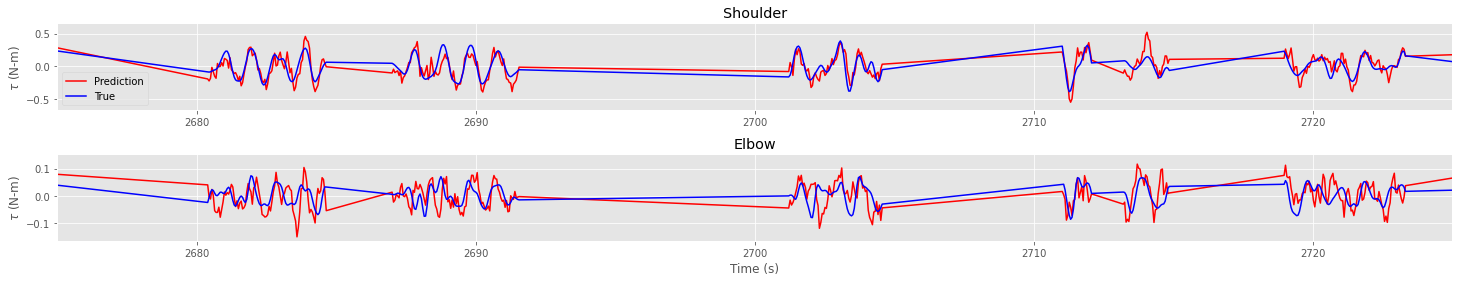

In [10]:
# Compute predictions on fully trained model for val set
predict_plot(benchmark_lnr, Xval, yval, time_val, 
             output_names, xlims=[2675,2725])

# Principal Component Analysis

In [11]:
""" TODO
Create a PCA object and fit it on the training set with whiten=True
"""
model = PCA(whiten=True)
model.fit(Xtrain, ytrain)

PCA(whiten=True)

Text(0.5, 1.0, 'Cumulative Fraction of Variance Explained')

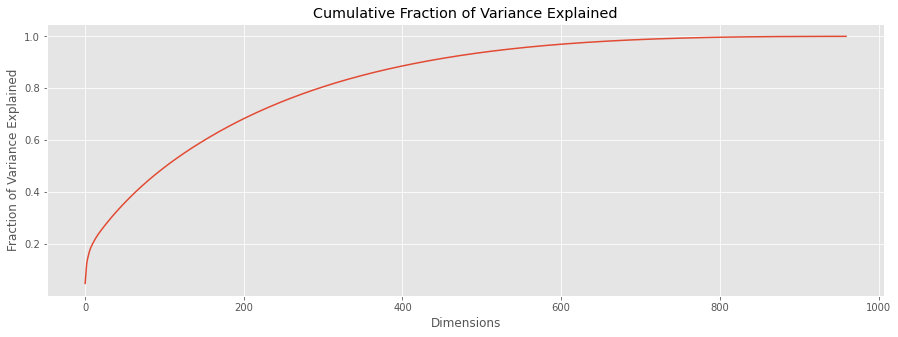

In [12]:
""" TODO
Get an idea of the number of PCs neccessary to represent the data
Use pca.explained_variance_ratio to get a fraction for each 
corresponding PC, and np.cumsum() to get the cumuluative sums as 
each component is successively considered.
"""
# TODO: Compute the cumulative fraction of explained variance
explained = model.explained_variance_ratio_.cumsum()

# Plot the cumulative fraction of explained variance
plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT))
plt.plot(explained)
plt.xlabel('Dimensions')
plt.ylabel('Fraction of Variance Explained')
plt.title('Cumulative Fraction of Variance Explained')


In [13]:
""" TODO
Obtain the minimum number of PCs necessary to account for 95% of 
the total variance. You can use np.where to locate the indices in 
the cumulative sum that is greater than or equal to .95, and then 
add 1 to the list of indices returned to get the number of PCs.
The first element in the list is the minimum number of PCs to
account for 95% of the variance.
"""
majority_explained = [pc+1 for pc in np.where(explained >= .95)][0]
# Display the determined number of PCs
nPCs = majority_explained[0]
nPCs

533

In [14]:
""" TODO
Using the number of PCs obtained above, re-fit the PCA with
whiten=True and project the training data into PC space
"""
pca = PCA(n_components = nPCs, whiten=True)
pca.fit(Xtrain)

# TODO: Project into PC-space
Xtrain_pca = pca.transform(Xtrain)
Xtrain_pca.shape

(1194, 533)

In [35]:
# TODO: Project back into the original space
Xtrain_recon = pca.inverse_transform(Xtrain_pca)
Xtrain_recon.shape

(1194, 960)

In [16]:
# TODO: Compute the reconstruction error (rmse)
rmse = compute_rmse(Xtrain, Xtrain_recon)

In [17]:
""" TODO
Implement a model Pipeline. The first step of the pipeline is 
PCA with n_components set to the number of PCs determined above
and whiten to true; and the second step of the pipeline is
LinearRegression()
"""
# TODO: Create Pipeline model
pca_model = Pipeline([
    ('PCA', PCA(n_components = nPCs, whiten=True)), 
    ('Regression', LinearRegression())
])

# TODO: Fit model to entire train set
pca_model.fit(Xtrain,ytrain)


Pipeline(steps=[('PCA', PCA(n_components=533, whiten=True)),
                ('Regression', LinearRegression())])

RMSE: 0.031
R^2: 0.868


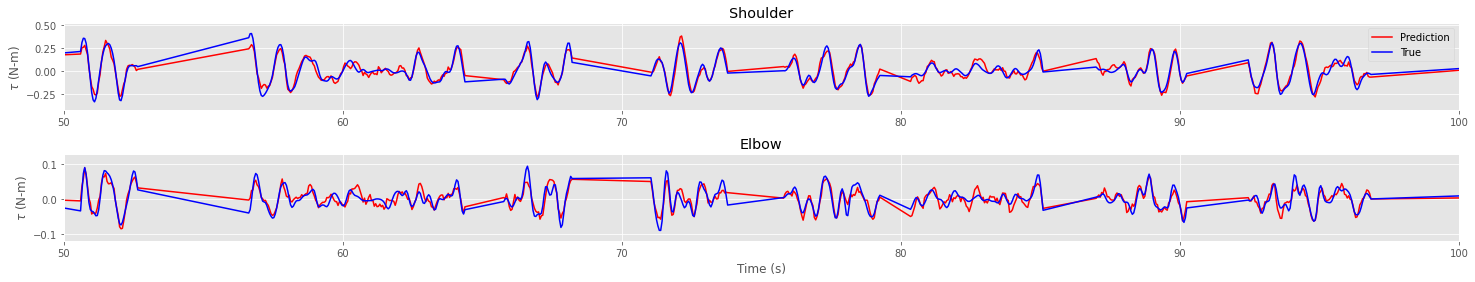

In [18]:
# TODO: Compute predictions on fully trained model for train set
# Display the plot of the true output overlaying the predicted output
# You can use predict_plot() with xlims=[50,100]
predict_plot(pca_model, Xtrain, ytrain, time_trn, 
             output_names, xlims=[50,100])


RMSE: 0.053
R^2: 0.616


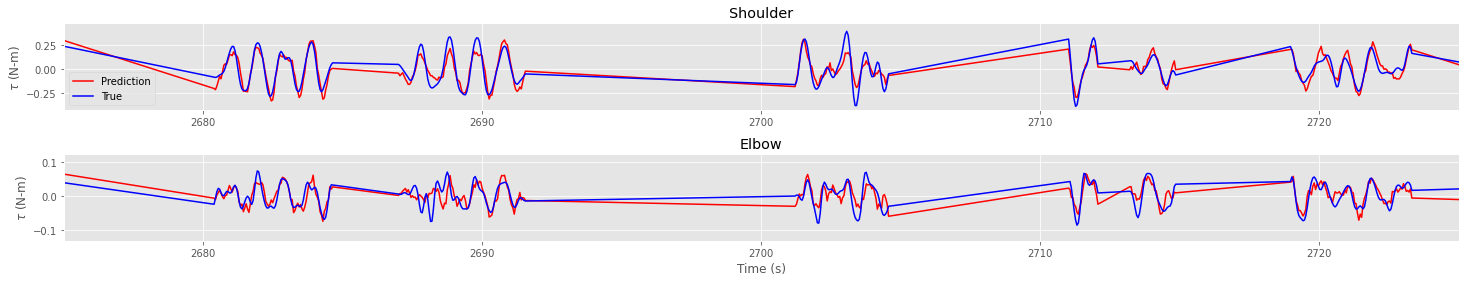

In [19]:
# TODO: Compute predictions on fully trained model for val set
# Display the plot of the true output overlaying the predicted output
# You can use predict_plot() with xlims=[2675,2725]
predict_plot(pca_model, Xval, yval, time_val, 
             output_names, xlims=[2675,2725])


### GRIDSEARCH KFoldHolisticCrossValidation
Use the KFoldHolisticCrossValidation from the HW 11 folder to show training and validation set performance as a function of data set size. The hyper-parameter you should vary for PCA is n_components. Briefly discuss and interepret the results of the GridSearch in terms of train size, performance, and variations in the hyper-parameters.

In [20]:
""" PROVIDED
Evaulation function for KFoldHolisticCrossValidation
"""
def mse_rmse(trues, preds):
    '''
    Compute MSE and rMSE for each column separately.
    '''
    mse = np.sum(np.square(trues - preds), axis=0) / trues.shape[0]
    rmse = np.sqrt(mse)
    return mse, rmse

def score_eval(model, X, y, preds):
    '''
    Compute the model predictions and corresponding scores, for an
    already trained model.
    PARAMS:
        model: model to predict with
        X: input feature data
        y: true output for X
        preds: predicted output for X
    RETURNS: results as a dictionary of numpy arrays
        mse: mean squared error for each column
        rmse: rMSE
        evar: explained variance, best is 1.0
        score: score computed by the models score() method
    '''
    score = model.score(X, y)

    mse, rmse = mse_rmse(y, preds)
    evar = explained_variance_score(y, preds)
    
    # Dictionary of numpy arrays. The numpy arrays must
    # be row vectors, where each element is the result 
    # for a different output, when using multiple regression.
    # The keys of the dictionary are the name of the performance 
    # metric, and the values are the numpy row vectors
    results = {'mse': np.reshape(mse, (1, -1)), 
               'rmse': np.reshape(rmse, (1, -1)), 
               'evar': np.reshape(evar, (1, -1)), 
               'score': np.reshape(score, (1, -1)), 
              }
    return results

In [21]:
# List of number of PCs to try
components = np.append(np.logspace(0, 5, num=6, base=3, dtype=int), nPCs)
components

array([  1,   3,   9,  27,  81, 243, 533])

In [22]:
""" TODO
Create the KFoldHolisticCrossValidation object using the PCA 
pipeline model created above
Estimated runtime <20 minutes on OSCER
"""
# Grid Search Parameters
opt_metric = 'rmse'
maximize_opt_metric = False
trainsizes = range(1, 11)
rotation_skip = 1

# TODO: GridSearch pipeline hyper-parameters can be specified 
# with ‘__’ separated parameter names
hyperparam_grid = {
    'PCA__n_components': components,
    'PCA__whiten': [True]
}
hyperparams = generate_paramsets(hyperparam_grid)
nhyperparams = len(hyperparams)


# TODO: Save Parameters. Set these appropriately
force = False 
write_crossval = True
fullcvfname = "hw11_crossval_%02dparams.pkl" % nhyperparams


if force or (not os.path.exists(fullcvfname)):
    # TODO: Create the cross validation object. use score_eval for the eval_func
    crossval = KFoldHolisticCrossValidation(pca_model, hyperparams, score_eval, opt_metric, 
                 maximize_opt_metric, trainsizes, rotation_skip)

    t0 = timelib.time()
    # TODO: Execute cross validation for all parameters and sizes
    crossval.grid_cross_validation(MI_folds, torque_folds)
    
    # TODO: Save the cross validation object. Can use joblib.dump()
    if write_crossval: joblib.dump(crossval, fullcvfname)
    
    lapsedTime = timelib.time() - t0
    print(" ** Elapsed Time %.2f min" % (lapsedTime / 60))

else:
    # TODO: Load the cross val object from file. Can use joblib.load()
    crossval = joblib.load(fullcvfname)
    
crossval.model, crossval.rotation_skip, crossval.trainsizes

(Pipeline(steps=[('PCA', PCA(n_components=533, whiten=True)),
                 ('Regression', LinearRegression())]),
 1,
 range(1, 11))

In [23]:
""" TODO
Display the lists of the best parameter sets for each size 
from the cross validation using get_report_best_params_all_sizes
"""
display(crossval.get_report_best_params_all_sizes())


Best Parameter Sets For Each Train Set Size


,train_size,param_index,paramset
0,1,4,"{'PCA__n_components': 81, 'PCA__whiten': True}"
1,2,4,"{'PCA__n_components': 81, 'PCA__whiten': True}"
2,3,5,"{'PCA__n_components': 243, 'PCA__whiten': True}"
3,4,5,"{'PCA__n_components': 243, 'PCA__whiten': True}"
4,5,5,"{'PCA__n_components': 243, 'PCA__whiten': True}"
5,6,6,"{'PCA__n_components': 533, 'PCA__whiten': True}"
6,7,6,"{'PCA__n_components': 533, 'PCA__whiten': True}"
7,8,6,"{'PCA__n_components': 533, 'PCA__whiten': True}"
8,9,6,"{'PCA__n_components': 533, 'PCA__whiten': True}"
9,10,6,"{'PCA__n_components': 533, 'PCA__whiten': True}"


(<Figure size 720x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'train Set Performance'}, ylabel='rmse_mean'>,
        <AxesSubplot:title={'center':'val Set Performance'}, xlabel='Train Set Size (# of folds)', ylabel='rmse_mean'>],
       dtype=object))

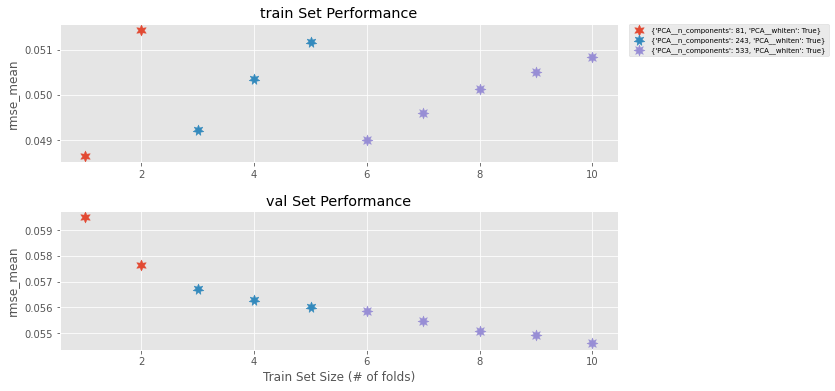

In [24]:
""" TODO
Plot the mean (summary) train and validation set performances for 
the best parameter set for each train size for the optimized
metrics. Use plot_best_params_by_size()
"""
crossval.plot_best_params_by_size()


In [25]:
""" PROVIDED
Display available metrics
"""
crossval.results[0]['results']['val'].keys()

dict_keys(['mse', 'rmse', 'evar', 'score'])

In [26]:
""" PROVIDED
Display available summary (mean and std) metrics
"""
crossval.results[0]['summary']['val'].keys()

dict_keys(['mse_mean', 'mse_std', 'rmse_mean', 'rmse_std', 'evar_mean', 'evar_std', 'score_mean', 'score_std'])

(<Figure size 720x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Validation Performance'}, ylabel='rmse_mean'>,
        <AxesSubplot:xlabel='Train Set Size (# of folds)', ylabel='evar_mean'>],
       dtype=object))

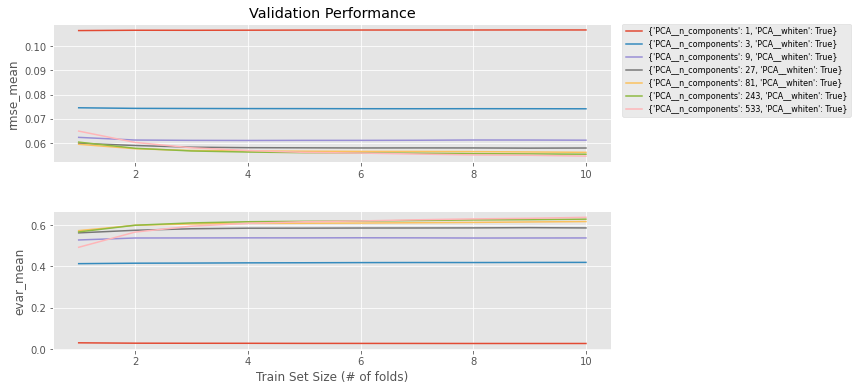

In [27]:
""" TODO
Plot the validation results for all parameter sets over all train 
sizes, for the specified metrics, rmse_mean and evar_mean
(this variable is declared above). Use plot_allparams_val()
"""
metrics = ['rmse_mean', 'evar_mean']

crossval.plot_allparams_val(metrics)

Train Set Size 1


(<Figure size 864x432 with 1 Axes>,
 array([<AxesSubplot:title={'center':"{'PCA__n_components': 81, 'PCA__whiten': True}"}, xlabel='Train Set Size (# of folds)', ylabel='rmse_mean'>],
       dtype=object))

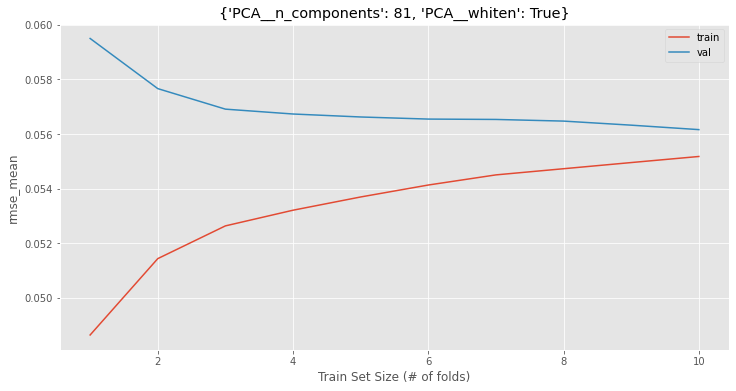

In [28]:
""" TODO
For the best parameter set for the train set sizes at 
size_idx=0 (i.e. 1 fold), plot just the TRAIN and VAL set performances using 
plot_param_train_val() for just the opt_metric
"""
size_idx = 0
print("Train Set Size", trainsizes[size_idx])
bp_idx = crossval.best_param_inds[size_idx]
# TODO: call plot_param_train_val()
crossval.plot_param_train_val([crossval.opt_metric], bp_idx)

In [29]:
""" PROVIDED
Re-fit PCA model with best hyper-parameters for train size of 
1 fold
"""
print("Train size %d folds" % trainsizes[0])

bp_idx = crossval.best_param_inds[0]
best_params = crossval.paramsets[bp_idx]

# Set the hyperparameters of the Pipeline model
pca_model.set_params(**best_params)

# Fit the model to entire train set
pca_model.fit(Xtrain, ytrain)

Train size 1 folds


Pipeline(steps=[('PCA', PCA(n_components=81, whiten=True)),
                ('Regression', LinearRegression())])

RMSE: 0.043
R^2: 0.732


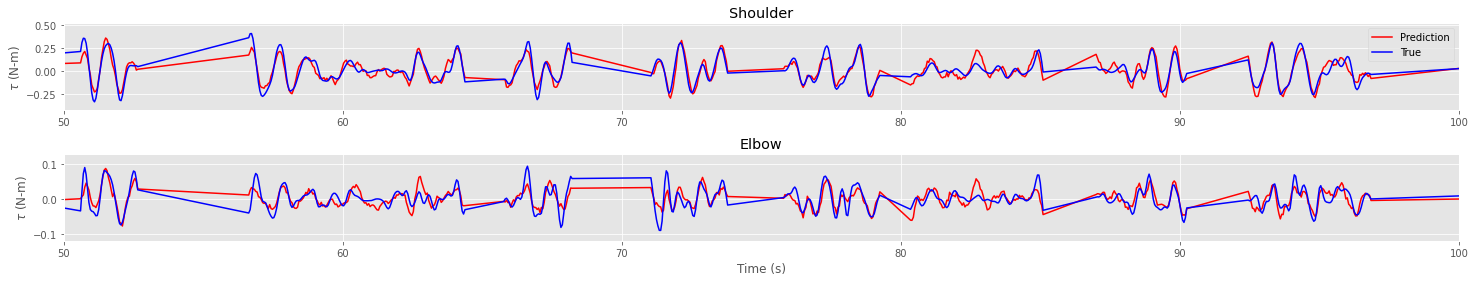

In [30]:
# TODO: Compute predictions on fully trained model for train set
# Display the plot of the true output overlaying the predicted output
# You can use predict_plot() with xlims=[50,100]
predict_plot(pca_model, Xtrain, ytrain, time_trn, output_names, xlims=[50,100])


RMSE: 0.049
R^2: 0.640


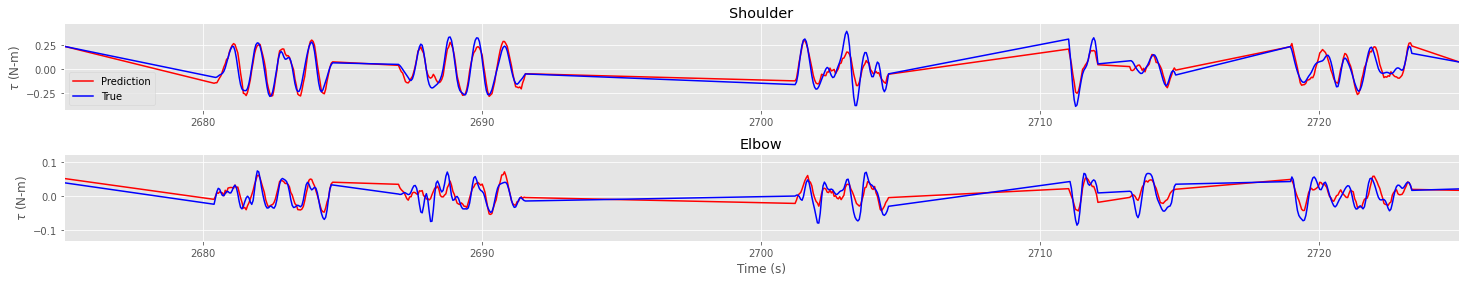

In [31]:
# TODO: Compute predictions on fully trained model for val set
# Display the plot of the true output overlaying the predicted output
# You can use predict_plot() with xlims=[2675,2725]

predict_plot(pca_model, Xval, yval, time_val, output_names, xlims=[2675,2725])

# DISCUSSION
1. Bake off. Compare the training and validation performances of the benchmark linear model learned without PCA to the model learned using PCA for train size of 1 fold. Based on the validation performances, which would you choose and why?

    I woud say that the prediction on the vaidation set perfomed better with pca. The predictions are closer to the true values without being too perfect for realism, where as the benchmark linear models validation performance was too spikey and not as reliable. 

2. Now that you've selected your model, observe and compare the test set results. Was your selection justified? Why or why not?

    Yes, because the predictions look more reliable than the linear model.

In [32]:
# TODO: set these paths appropriately
# Re-load saved favorite crossval object
r_crossval = joblib.load('/home/nigel/Desktop/mlp/hw7/hw7_full_ridge_crossval.pkl')
# Re-load saved linear crossval object
lnr_crossval = joblib.load('/home/nigel/Desktop/mlp/hw7/hw7_full_linear_crossval.pkl')

/home/nigel/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/nigel/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


(<Figure size 864x432 with 1 Axes>,
 array([<AxesSubplot:title={'center':'{}'}, xlabel='Train Set Size (# of folds)', ylabel='rmse_mean'>],
       dtype=object))

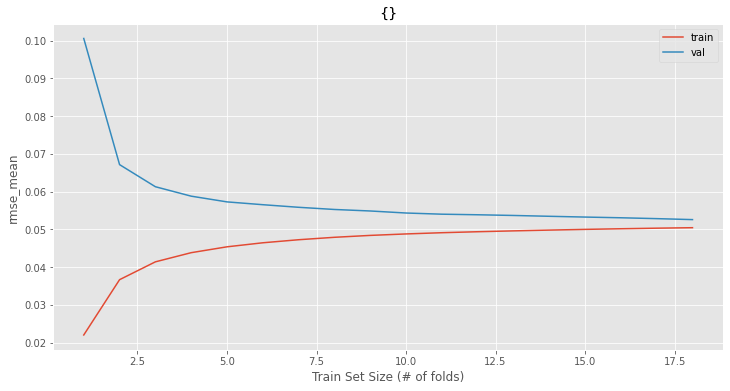

In [33]:
"""
Display Linear Regression model performance
"""
lnr_crossval.plot_param_train_val([lnr_crossval.opt_metric])

In [ ]:
# TODO: any additional plots or tables relevant to your discussion responses